In [1]:
# References:
# https://huggingface.co/microsoft/Phi-3-vision-128k-instruct
# https://towardsdatascience.com/6-real-world-uses-of-microsofts-newest-phi-3-vision-language-model-8ebbfa317fe8

In [1]:
#!pip install transformers
#!pip install bitsandbytes
#!FLASH_ATTENTION_SKIP_CUDA_BUILD=TRUE pip install flash-attn --no-build-isolation
#!pip install accelerate

In [2]:
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
import torch

/home/bob/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define model ID
model_id = "microsoft/Phi-3-vision-128k-instruct"

# Load processor
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# Define BitsAndBytes configuration for 4-bit quantization
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load model with 4-bit quantization and map to CUDA
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    trust_remote_code=True,
    torch_dtype="auto",
    quantization_config=nf4_config,
)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.14s/it]


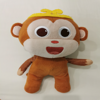

The image shows a plush toy resembling a monkey with a yellow headband.


In [16]:
# Define initial chat message with image placeholder
messages = [{"role": "user", "content": "<|image_1|>\nWhat is shown in this image?"}]

# Download image from URL
#url = "https://images.unsplash.com/photo-1528834342297-fdefb9a5a92b?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=roonz-nl-vjDbHCjHlEY-unsplash.jpg&w=640"
#image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("0.jpg")
image.resize((100,100)).show()

# Prepare prompt with image token
prompt = processor.tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

# Process prompt and image for model input
inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

# Generate text response using model
generate_ids = model.generate(
    **inputs,
    eos_token_id=processor.tokenizer.eos_token_id,
    max_new_tokens=500,
    do_sample=False,
)

# Remove input tokens from generated response
generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

# Decode generated IDs to text
response = processor.batch_decode(
    generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

# Print the generated response
print(response)

In [7]:
#OCR
messages = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image as is. OCR:"}]
image = Image.open("SpellingList3.jpg")

# Prepare prompt with image token
prompt = processor.tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

# Process prompt and image for model input
inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

# Generate text response using model
generate_ids = model.generate(
    **inputs,
    eos_token_id=processor.tokenizer.eos_token_id,
    max_new_tokens=500,
    do_sample=False,
)

# Remove input tokens from generated response
generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

# Decode generated IDs to text
response = processor.batch_decode(
    generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

# Print the generated response
print(response)

SPELLING & DICTATION LIST 3 (TERM 2)
Please note that you will be tested on the words and sentences that 
are underlined and in BOLD.
Book: Walking Through the Jungle
Week 8: 6 May 2024 (Monday)
1. 
That is a long snake.
2. 
The monkey swings from tree to tree.
3. 
The elephant has a long trunk.
4. 
The leopard is creeping through the jungle.
5. 
An animal is leaping through the jungle.
6. 
The tiger is a ferocious animal.
7. 
Peter is walking quickly.
8. 
Can you hear a noise?
DICTATION
9. 
The lion roars loudly.
10. 
The horse gallops in the field.
Term 2 Spelling 
Page 3


In [8]:
# chat
user_prompt = '<|user|>\n'
assistant_prompt = '<|assistant|>\n'
prompt_suffix = "<|end|>\n"

prompt = f"{user_prompt}what is the answer for 1+1? Explain it.{prompt_suffix}{assistant_prompt}"
print(f">>> Prompt\n{prompt}")
inputs = processor(prompt, images=None, return_tensors="pt").to("cuda:0")
generate_ids = model.generate(**inputs, 
                              max_new_tokens=1000,
                              eos_token_id=processor.tokenizer.eos_token_id,
                              )
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, 
                                  skip_special_tokens=True, 
                                  clean_up_tokenization_spaces=False)[0]
print(f'>>> Response\n{response}')

>>> Prompt
<|user|>
what is the answer for 1+1? Explain it.<|end|>
<|assistant|>

>>> Response
The answer to 1+1 is 2. This is a basic arithmetic operation known as addition, which combines two numbers, in this case, 1 and 1, to produce a total sum. The principle behind addition is that when you have a certain quantity and you add another identical quantity to it, the total quantity increases by one. So, when you add 1 to 1, you get 2 because you have one more than the original amount.
